In [200]:
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt

# 지도 이미지 로드
pgm_img = cv2.imread('map_baby.pgm', cv2.IMREAD_GRAYSCALE)
# PNG로 저장
cv2.imwrite('map.png', pgm_img)

True

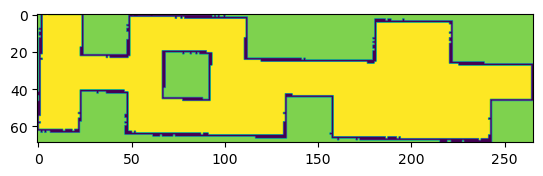

In [201]:
map_img = cv2.imread("map.png",cv2.COLOR_BGR2GRAY )
plt.imshow(map_img)

In [202]:
map_img[1,1]

205

In [203]:
# opencv 이미지 그리드 분할 생각해보면 가로몇개로 할지, 세로 몇개로할지가 문제인데
# 여기까지는 사람의 손이 들어가야할 파라미터라고 생각됨. 파라미터가 많아질수록 복잡해지고, 파라미터가 적을수록 단순해진다.

In [204]:
def image_Grid(h, w, img):
    img_height, img_width = img.shape
    grid_size = (h, w)  # 세로, 가로
    
    # 그리드 영역 크기 계산
    cell_height = img_height // grid_size[0]
    cell_width = img_width // grid_size[1]

    
    map_cost = []
    map_col = []
    
    #각각의 그리드 영역에서 흰색 픽셀 비율 계산
    for i in range(grid_size[0]):
        map_col = []
        for j in range(grid_size[1]):
            # 그리드 영역의 범위를 지정하는거고
            cell_top = i * cell_height
            cell_left = j * cell_width
            cell_bottom = cell_top + cell_height
            cell_right = cell_left + cell_width
            
            
            if i == h-1:
                cell_bottom = img_height
                
            
            # 그 맵의 모든 픽셀을 가져와서
            cell = img[cell_top:cell_bottom, cell_left:cell_right]
            

            wall = 0
            load = 0
            for row in range(len(cell)):
                for col in range(len(cell[0])):
                
                    if cell[row][col] <= 210:
                        wall += 1;
                    else:
                        load += 1
            
                
            if load > wall:
                map_col.append(0)
            else:
                map_col.append(1)
        
        map_cost.append(map_col)
                
    return map_cost

In [205]:
map_param = image_Grid(3, 12, map_img)
for i in map_param:
    print(i)

[0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


In [206]:
class Astar:
    def __init__(self, parent=None, position=None):
        self.parent = parent
        self.position = position

        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.position == other.position

    def heuristic(self, node, goal, D=1, D2=2 ** 0.5):  # Diagonal Distance
        dx = abs(node.position[0] - goal.position[0])
        dy = abs(node.position[1] - goal.position[1])
        return D * (dx + dy)


    def aStar(self, maze, start, end):
        # startNode와 endNode 초기화
        startNode = Node(None, start)
        endNode = Node(None, end)

        # openList, closedList 초기화
        openList = []
        closedList = []

        # openList에 시작 노드 추가
        openList.append(startNode)

        # endNode를 찾을 때까지 실행
        while openList:

            # 현재 노드 지정
            currentNode = openList[0]
            currentIdx = 0

            # 이미 같은 노드가 openList에 있고, f 값이 더 크면
            # currentNode를 openList안에 있는 값으로 교체
            for index, item in enumerate(openList):
                if item.f < currentNode.f:
                    currentNode = item
                    currentIdx = index

            # openList에서 제거하고 closedList에 추가
            openList.pop(currentIdx)
            closedList.append(currentNode)

            # 현재 노드가 목적지면 current.position 추가하고
            # current의 부모로 이동
            if currentNode == endNode:
                path = []
                current = currentNode
                while current is not None:
                    # maze 길을 표시하려면 주석 해제
                    x, y = current.position
                    maze[x][y] = 2
                    path.append(current.position)
                    current = current.parent
                return path[::-1]  # reverse

            children = []
            # 인접한 xy좌표 전부
            for newPosition in [(0, -1), (0, 1), (-1, 0), (1, 0)]:

                # 노드 위치 업데이트
                nodePosition = (
                    currentNode.position[0] + newPosition[0],  # X
                    currentNode.position[1] + newPosition[1])  # Y
                    
                # 미로 maze index 범위 안에 있어야함
                within_range_criteria = [
                    nodePosition[0] > (len(maze) - 1),
                    nodePosition[0] < 0,
                    nodePosition[1] > (len(maze[len(maze) - 1]) - 1),
                    nodePosition[1] < 0,
                ]

                if any(within_range_criteria):  # 하나라도 true면 범위 밖임
                    continue

                # 장애물이 있으면 다른 위치 불러오기
                if maze[nodePosition[0]][nodePosition[1]] != 0:
                    continue

                new_node = Node(currentNode, nodePosition)
                children.append(new_node)

            # 자식들 모두 loop
            for child in children:

                # 자식이 closedList에 있으면 continue
                if child in closedList:
                    continue

                # f, g, h값 업데이트
                child.g = currentNode.g + 1
                child.h = ((child.position[0] - endNode.position[0]) **
                        2) + ((child.position[1] - endNode.position[1]) ** 2)
                # child.h = heuristic(child, endNode) 다른 휴리스틱
                # print("position:", child.position) 거리 추정 값 보기
                # print("from child to goal:", child.h)
                
                child.f = child.g + child.h

                # 자식이 openList에 있으고, g값이 더 크면 continue
                if len([openNode for openNode in openList
                        if child == openNode and child.g > openNode.g]) > 0:
                    continue
                        
                openList.append(child)

    def run(self, maze, start, end):
        path = self.aStar(maze, start, end)
        return maze, path


맵입니다.
[0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]

경로 생성 맵입니다. 숫자 2는 경로입니다.
[2, 1, 2, 2, 2, 1, 1, 1, 0, 0, 1, 1]
[2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


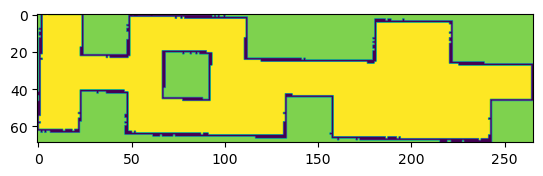

In [210]:
plt.imshow(map_img)



map_param = image_Grid(3, 12, map_img)

print("맵입니다.")
for i in map_param:
    print(i)
print()

make_route = Astar()
start = (1, 11)
end = (0, 0)
result, path = make_route.run(map_param , start, end)


print("경로 생성 맵입니다. 숫자 2는 경로입니다.")
for i in result:
    print(i)

In [ ]:
# 해야할일 이거 로스랑 연동시키기
# 각 지점 좌표값 받기 그 지점 좌표값까지는 Nav2로 이동시키기 
# 완성가능합니다.